## DNN

### libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### preprocessing.ipynb

In [2]:
df = pd.read_csv('Data/Raw Data.csv', header=0).astype(int).astype(str)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8


In [3]:
num_cols = [
    'Diabetes_binary',
    'BMI',
    'GenHlth',
    'MentHlth',
    'PhysHlth', 
]
for col in num_cols:
    df[col] = df[col].astype(int)

In [4]:
df['HighCholCheck'] = df['CholCheck'] + df['HighChol']

In [5]:
rearranged = [
    'Sex', 'Age',
    'Fruits', 'Veggies','HvyAlcoholConsump',
    'BMI', 'PhysActivity', 'DiffWalk', 'GenHlth', 'MentHlth', 'PhysHlth', 
    'HighCholCheck', 'HighBP', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'AnyHealthcare', 'NoDocbcCost',
    'Education', 'Income',
    'Diabetes_binary'
    ]

strat_cols = [
    'Sex', 'Age',
    'Diabetes_binary'
    ]

In [6]:
split = StratifiedShuffleSplit(n_splits=1,
                            test_size=0.2,
                            random_state=42)

for train_index, test_index in split.split(df, df[strat_cols]):
    train_indices = list(train_index)
    test_indices = list(test_index)
    
train_full = df.iloc[train_indices]
test_set = df.iloc[test_indices]

for train_index, val_index in split.split(train_full, train_full[strat_cols]):
    train_indices = list(train_index)
    val_indices = list(val_index)
    
train_set = train_full.iloc[train_indices]
val_set = train_full.iloc[val_indices]

In [7]:
train_set[rearranged].to_csv('Data/TTV Split/training.csv', index=False)
print(f'Training Set Saved: {len(train_set.columns)} Columns x {len(train_set)} Rows')
test_set[rearranged].to_csv('Data/TTV Split/testing.csv', index=False)
print(f'Testing Set Saved: {len(test_set.columns)} Columns x {len(test_set)} Rows')
val_set[rearranged].to_csv('Data/TTV Split/validation.csv', index=False)
print(f'Validation Set Saved: {len(val_set.columns)} Columns x {len(val_set)} Rows')

Training Set Saved: 23 Columns x 45242 Rows
Testing Set Saved: 23 Columns x 14139 Rows
Validation Set Saved: 23 Columns x 11311 Rows


### preprocessing and splitting data

In [8]:
bool_cols = [
    'Sex', 
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 
    'PhysActivity', 'DiffWalk',
    'HighBP', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'AnyHealthcare', 'NoDocbcCost',
    ]

categorical_cols = [
    'Age', 
    'GenHlth',
    'HighCholCheck',
    'Education', 'Income'
    ]

numerical_cols = [
    'BMI', 'MentHlth', 'PhysHlth',
    ]

goal_variable = 'Diabetes_binary'


In [9]:
def load_dnn_data():
    train = pd.read_csv("Data/TTV Split/training.csv", header=0)
    train_y = train[[goal_variable]]
    train_x = train.drop(goal_variable, axis=1)
    test = pd.read_csv("Data/TTV Split/testing.csv", header=0)
    test_y = test[[goal_variable]]
    test_x = test.drop(goal_variable, axis=1)
    val = pd.read_csv("Data/TTV Split/validation.csv", header=0)
    val_y = val[[goal_variable]]
    val_x = val.drop(goal_variable, axis=1)

    scaler = StandardScaler()
    
    train_x[numerical_cols] = scaler.fit_transform(train_x[numerical_cols])
    train_x = pd.get_dummies(train_x, columns=categorical_cols, drop_first=False)
    train_x = pd.get_dummies(train_x, columns=bool_cols, drop_first=True)
    train_x = train_x.astype(int)
    
    val_x[numerical_cols] = scaler.transform(val_x[numerical_cols])
    val_x = pd.get_dummies(val_x, columns=categorical_cols, drop_first=False)
    val_x = pd.get_dummies(val_x, columns=bool_cols, drop_first=True)
    val_x = val_x.astype(int)

    test_x[numerical_cols] = scaler.transform(test_x[numerical_cols])   
    test_x = pd.get_dummies(test_x, columns=categorical_cols, drop_first=False)
    test_x = pd.get_dummies(test_x, columns=bool_cols, drop_first=True)
    test_x = test_x.astype(int)
    
    return (train_x, np.array(train_y[goal_variable].values)), \
            (val_x, np.array(val_y[goal_variable].values)), \
            (test_x, np.array(test_y[goal_variable].values))

In [10]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_dnn_data()

### model building

In [11]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    Dropout(0.2),  
    Dense(64, activation='relu'),  
    Dropout(0.2),  
    Dense(32, activation='relu'),  
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

2024-04-25 15:03:13.617708: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-25 15:03:13.617750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-25 15:03:13.617761: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-25 15:03:13.619173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 15:03:13.619510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(train_x, train_y, epochs=20, validation_data=(val_x, val_y))

Epoch 1/20


2024-04-25 15:03:14.351871: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-25 15:03:14.589524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1414/1414 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7203

2024-04-25 15:03:25.758049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1414/1414 [==============================] - 13s 8ms/step - loss: 0.5603 - accuracy: 0.7203 - val_loss: 0.5283 - val_accuracy: 0.7372
Epoch 2/20
1414/1414 [==============================] - 10s 7ms/step - loss: 0.5548 - accuracy: 0.7250 - val_loss: 0.5584 - val_accuracy: 0.7290
Epoch 3/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.5552 - accuracy: 0.7275 - val_loss: 0.5276 - val_accuracy: 0.7372
Epoch 4/20
1414/1414 [==============================] - 9s 7ms/step - loss: 0.5719 - accuracy: 0.7217 - val_loss: 0.6984 - val_accuracy: 0.5281
Epoch 5/20
1414/1414 [==============================] - 9s 7ms/step - loss: 0.5880 - accuracy: 0.7159 - val_loss: 0.5305 - val_accuracy: 0.7338
Epoch 6/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6106 - accuracy: 0.7118 - val_loss: 0.5248 - val_accuracy: 0.7452
Epoch 7/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6502 - accuracy: 0.7023 - val_loss: 0.7565 - val_accuracy: 0.7289
E

In [14]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print("Testing loss:", test_loss)
print("Testing accuracy:", test_acc)

442/442 [==============================] - 1s 3ms/step - loss: 2.6750 - accuracy: 0.6370
Testing loss: 2.6750378608703613
Testing accuracy: 0.6369615793228149


In [15]:
y_pred = (model.predict(test_x) > 0.5).astype(int)

125/442 [=======>......................] - ETA: 0s

2024-04-25 15:06:19.058593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 1s 1ms/step


Confusion Matrix:


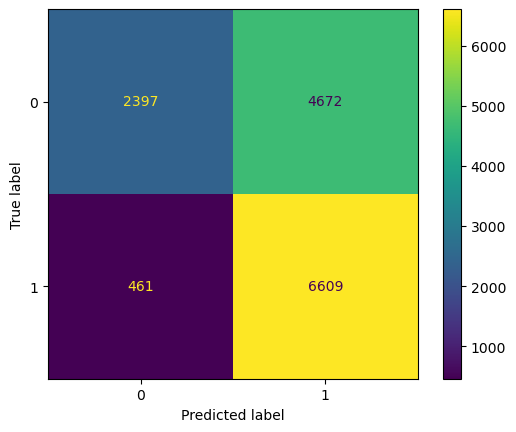

In [16]:
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [17]:
print("Classification Report:")
print(classification_report(test_y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.34      0.48      7069
           1       0.59      0.93      0.72      7070

    accuracy                           0.64     14139
   macro avg       0.71      0.64      0.60     14139
weighted avg       0.71      0.64      0.60     14139

